# PyJeo Implementation/Random Forest - Tutorial Test

## Installation of Packages/Modules

In [27]:
# #!pip install getpass
# import getpass
# import os

In [28]:
# password = getpass.getpass()
# command = "bash /media/sf_D_DRIVE/work/TCC_random_forest/install_pyjeo4osgeo16.sh -S" #can be any command but don't forget -S as it enables input from stdin
# os.system('echo %s | %s' % (password, command))

In [29]:
# import pandas as pd
# import numpy as np
# #import rasterio as rio
# import geopandas as gpd
# import rasterio
# import pyjeo

## Data from Classification in Python

In [30]:
# #need to activate the terminal
# !source $HOME/venv/bin/activate

In [31]:
from IPython.display import display
import geopandas as gpd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pyjeo as pj
import pandas as pd
import geopandas as gpd

## Create reference data for training

In [32]:
! curl -H 'Accept: application/vnd.github.v3.raw' -O -L 'https://github.com/ec-jrc/jeolib-pyjeo/raw/master/tests/data/modis_ndvi_training.sqlite'
! curl -H 'Accept: application/vnd.github.v3.raw' -O -L 'https://github.com/ec-jrc/jeolib-pyjeo/raw/master/tests/data/modis_ndvi_2010.tif'


!pwd

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 24576  100 24576    0     0  30886      0 --:--:-- --:--:-- --:--:--     0
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3079k  100 3079k    0     0   631k      0  0:00:04  0:00:04 --:--:--  824k
/media/sf_D_DRIVE/work/TCC_random_forest


In [33]:
reference = pj.JimVect('modis_ndvi_training.sqlite')
reference

In [34]:
jim = pj.Jim('modis_ndvi_2010.tif', band2plane=True)
jim

In [35]:
dates = [datetime.strptime('01-' + str(month) + '-2010', "%d-%m-%Y") for month in range(1, 13)]
jim.properties.setDimension({'band': ['NDVI'], 'plane': dates})

In [36]:
jim.xr() #note that this is an xarray dataset now

<xarray.Dataset> Size: 3MB
Dimensions:      (time: 12, y: 512, x: 512)
Coordinates:
  * time         (time) datetime64[ns] 96B 2010-01-01 2010-02-01 ... 2010-12-01
  * y            (y) float64 4kB 2.673e+06 2.672e+06 ... 2.418e+06 2.418e+06
  * x            (x) float64 4kB 4.172e+06 4.173e+06 ... 4.428e+06 4.428e+06
    spatial_ref  int64 8B 0
Data variables:
    NDVI         (time, y, x) uint8 3MB 17 22 18 14 8 3 5 ... 29 23 26 28 15 23

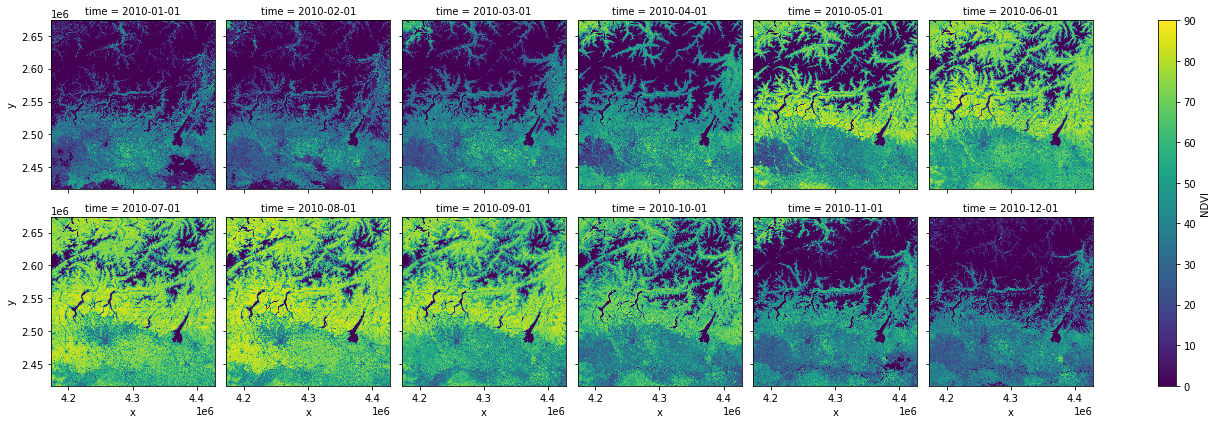

In [37]:
jim.xr().NDVI.plot(col='time', col_wrap=6)

## Dataframe

In [38]:
# pd.DataFrame(modis_ndvi_training.sqlite)
reference.dict()

{'label': [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]}

In [39]:
pd.DataFrame(reference.dict())

,label
0,1
1,1
2,1
3,1
4,1
5,1
6,2
7,2
8,2
9,2


Based on the above, we've extracted all of the features (i.e., the entire stack's pixels) into a table, and converted it into a geodataframe.

In [40]:
featurevect = pj.geometry.extract(reference, jim, rule=['allpoints'],
                                  output='/vsimem/features.sqlite',
                                  oformat='SQLite',
                                  co=['OVERWRITE=YES'],
                                  classes=[1, 2],
                                  copy='label')
gdf = gpd.read_file('/vsimem/features.sqlite')
gdf

,label,t0b0,t1b0,t2b0,t3b0,t4b0,t5b0,t6b0,t7b0,t8b0,t9b0,t10b0,t11b0,geometry
0,1,0.0,0.0,0.0,0.0,2.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,POINT (4263500.000 2546500.000)
1,1,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,POINT (4263500.000 2546000.000)
2,1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,POINT (4264000.000 2546000.000)
3,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,POINT (4263500.000 2545500.000)
4,1,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (4264000.000 2545500.000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,2,3.0,5.0,39.0,51.0,65.0,63.0,54.0,46.0,48.0,47.0,46.0,38.0,POINT (4260500.000 2424000.000)
303,2,0.0,4.0,34.0,54.0,70.0,63.0,60.0,56.0,52.0,55.0,51.0,40.0,POINT (4261000.000 2424000.000)
304,2,0.0,3.0,37.0,55.0,75.0,69.0,69.0,66.0,62.0,60.0,50.0,34.0,POINT (4261500.000 2424000.000)
305,2,4.0,10.0,46.0,56.0,69.0,64.0,56.0,53.0,53.0,53.0,46.0,38.0,POINT (4260500.000 2423500.000)


In [ ]:
plt.figure(figsize=(16, 8))
ax = plt.subplot()
jim.xr().NDVI.isel(time = 0).plot(ax = ax)
gdf.plot(column = 'label', ax = ax, legend = True, categorical=True, cmap='Set1')

In [ ]:
pd.DataFrame(featurevect.dict())

## Train the Model

In [ ]:
x = featurevect.np()[:, 1:]
y = featurevect.np()[:, 0:1]
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.33,
                                                    random_state=42)
rfModel = RandomForestClassifier(n_estimators=100,
                                 max_depth=9,
                                 min_samples_leaf=5,
                                 min_samples_split=3,
                                 criterion='gini')
rfModel.fit(x_train, y_train.ravel())

In [ ]:
y_predict = rfModel.predict(x_test)
print(confusion_matrix(y_test, y_predict))
print('accuracy score: {}'.format(accuracy_score(y_test, y_predict)))

## Prediction

In [ ]:
x = jim.np()
x

In [ ]:
## Check xarray properties
print("# of dimensions: ",x.ndim,"\nShape: ",x.shape,"\nSize: ",x.size)

In [ ]:
x = x.reshape(jim.properties.nrOfPlane(), jim.properties.nrOfRow() * \
                      jim.properties.nrOfCol()).T
x

In [ ]:
## Check xarray properties
print("# of dimensions: ",x.ndim,"\nShape: ",x.shape,"\nSize: ",x.size)

In [ ]:
## Check Jim Properties (to figure out what to reshape to) -- https://pyjeo.readthedocs.io/en/latest/3_reference.html#jim
print("# of Bands: ",jim.properties.nrOfBand(),"\n# of Planes: ",jim.properties.nrOfPlane(),"\n# of Rows: ",jim.properties.nrOfRow(),"\n# of Columns:", jim.properties.nrOfCol())

In [ ]:
jim_class = pj.Jim(ncol=jim.properties.nrOfCol(),
                   nrow=jim.properties.nrOfRow(),
                   otype='Byte')
jim_class

In [ ]:
jim_class.properties.copyGeoReference(jim)
jim_class.np()[:] = rfModel.predict(x).astype(np.dtype(np.uint8)).\
            reshape(jim.properties.nrOfRow(), jim.properties.nrOfCol())
jim_class.properties.setDimension(['water'], 'band')

In [ ]:
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(121)
jim.xr().NDVI.isel(time = 0).plot(ax = ax1)
ax2 = plt.subplot(122)
jim_class.xr().water.plot(cmap = 'Set2', levels = [1, 2], ax = ax2)